# Graph Coloring with Xanadu's Photonic Processor

Given some input graph, we can use Xanadu's Gaussian Boson Sampler to return to us with high probability a dense subgraph of the entire graph. We can use the results of the sampler to inform how we color our graph. We thus test the idea of Boson Sampling Enhanced Coloring (BSEC).

Because Xanadu's processor gives us access to 4 qumodes, we consider a 4 node graph

### Make some imports

In [1]:
# useful packages
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

### Draw an example 4 node graph we want to color

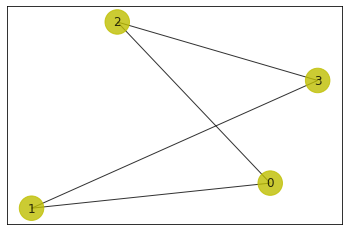

In [3]:
G = nx.Graph()
edges = [(0, 1), (0, 2), (3, 1), (3, 2)]
nodes = list(range(4))
G.add_edges_from(edges)
G.add_nodes_from(nodes)

pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
colors = ['y' for node in G.nodes()]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

### Extract SVD info of adjacency matrix of graph

In [38]:
A = np.array([[0,1,0,1], [1,0,1,1], [0,1,0,1], [1,1,1,0]])

_, svds, _ = np.linalg.svd(A)
#print(svds)
max_val = max(svds)
svds_scaled = svds/max_val
print(svds_scaled)

[1.00000000e+00 6.09611797e-01 3.90388203e-01 7.01840724e-17]


### Write up a circuit for Boson sampling:

We write the circuit for GBS based on the following:
<br>
<img src="https://s3.amazonaws.com/xanadu-img/gaussian_boson_sampling.svg" width=70%/>

<br>

In [5]:
import strawberryfields as sf
from strawberryfields.ops import *
from strawberryfields.utils import random_interferometer
from strawberryfields.decompositions import graph_embed

In [39]:
squeezes, U_Int = graph_embed(A)
print(U_Int)

[[-0.43516215+0.00000000e+00j  0.        -5.57345410e-01j
   0.        -1.11022302e-16j  0.        -7.07106781e-01j]
 [-0.55734541+0.00000000e+00j  0.        +4.35162146e-01j
   0.        -7.07106781e-01j  0.        +0.00000000e+00j]
 [-0.43516215+0.00000000e+00j  0.        -5.57345410e-01j
   0.        -5.55111512e-17j  0.        +7.07106781e-01j]
 [-0.55734541+0.00000000e+00j  0.        +4.35162146e-01j
   0.        +7.07106781e-01j  0.        +0.00000000e+00j]]


In [25]:
program = sf.io.load('chip0.xbb')
eng = sf.StarshipEngine()

AttributeError: module 'strawberryfields' has no attribute 'StarshipEngine'

In [ ]:
results = eng.run(program)

In [ ]:
results.samples.T

In [44]:
# Sim
#eng = sf.Engine('gaussian')

# Hardware

gbs = sf.Program(4)

with gbs.context as q:
    # prepare the input squeezed states
    for i in range(4):
        Sgate(squeezes[i]) | q[i]
    
    '''
    # apply rotation gates, parameterized by svds
    for i in range(4):
        R(svds_scaled[i]) | q[i]
    
    
    # Beamsplitters
    BS() | [q[0], q[1]]
    BS() | [q[2], q[3]]
    
    BS() | [q[1], q[2]]
    
    BS() | [q[0], q[1]]
    BS() | [q[2], q[3]]
    
    BS() | [q[1], q[2]]
    
    BS() | [q[0], q[1]]
    BS() | [q[2], q[3]]
    '''
    
    # linear interferometer
    Interferometer(U_Int) | q
   
    MeasureFock() | q
eng.print_applied()
#results = eng.run(gbs, run_options={"shots":1000})

Run 0:
Sgate(-1.379, 0) | (q[0])
Sgate(-0.5999, 0) | (q[1])
Sgate(-0.3585, 0) | (q[2])
Sgate(-0, 0) | (q[3])
Rgate(1.571) | (q[0])
BSgate(0.9079, 0) | (q[0], q[1])
Rgate(-0.3617) | (q[2])
BSgate(1.571, 0) | (q[2], q[3])
Rgate(-0.3617) | (q[1])
BSgate(1.571, 0) | (q[1], q[2])
BSgate(0.7854, 0) | (q[0], q[1])
Rgate(1.571) | (q[0])
Rgate(-1.571) | (q[1])
Rgate(-1.209) | (q[2])
Rgate(1.932) | (q[3])
BSgate(-0.7854, 0) | (q[2], q[3])
Rgate(-0.3617) | (q[2])
BSgate(-1.571, 0) | (q[1], q[2])
Rgate(-2.78) | (q[1])
Measure | (q[0], q[1], q[2], q[3])


### Samples

In [8]:
samples = results.samples

### Post-Processing

In [9]:
def threshold(samples):
    for sample in samples:
        for i in range(len(sample)):
            if sample[i] >= 1:
                sample[i] = 1
                
def post_select(samples):
    new_samples = []
    for i in range(len(samples)):
        if np.sum(samples[i]) == 3:
            new_samples.append(samples[i])
    return new_samples

def samples_to_subgraph(sample):
    subgraph = []
    for i in range(len(sample)):
        if sample[i] == 1:
            subgraph.append(i)
    return subgraph   

In [10]:
threshold(samples)
temp = post_select(samples)

subgraphs = []
for i in range(len(temp)):
    subgraphs.append(samples_to_subgraph(temp[i]))

### Coloring

In [11]:
def lf(A, nodes,colors):
    sums = []
    for i in range(len(A)):
        sums.append((np.sum(A[i]), i))
    sums.sort(key=lambda tup: tup[0], reverse=True)
    
    colors = np.zeros(len(nodes))
    colors[0] = 1
    for i in range(1, len(sums)):
        maximum = 0
        for j in range(0,i):
            if A[sums[i][1]][sums[j][1]] != 0:
                if colors[sums[j][1]] > maximum:
                    maximum = colors[sums[j][1]] + 1
        colors[i] = maximum
    return colors

def colorcheck(colors):
    everythingcolored = True
    i = 0
    while everythingcolored and i < len(colors):
        everythingcolored = colors[i] != 0
        i += 1
    return everythingcolored

In [12]:
from typing import Union
graph_type = Union[nx.Graph, np.ndarray]



def to_networkx_graph(graph: graph_type) -> nx.Graph:
    """Converts input graph into a NetworkX graph.

    Given an input graph of type ``graph_type = Union[nx.Graph, np.ndarray]``, this function
    outputs a NetworkX graph of type ``nx.Graph``. The input ``np.ndarray`` must be an adjacency
    matrix (i.e., satisfy :func:`is_adjacency`) and also real.

    Args:
        graph (graph_type): input graph to be processed

    Returns:
        graph: the NetworkX graph corresponding to the input
    """

    if isinstance(graph, np.ndarray):
        if not is_adjacency(graph) or not np.allclose(graph, graph.conj()):
            raise ValueError("Adjacency matrix must be real and symmetric")

        graph = nx.Graph(graph)

    elif not isinstance(graph, nx.Graph):
        raise TypeError("Graph is not of valid type")

    return graph



#[docs]
def is_adjacency(mat: np.ndarray) -> bool:
    """Checks if input is an adjacency matrix, i.e., symmetric.

    Args:
        mat (array): input matrix to be checked

    Returns:
        bool: returns ``True`` if input array is an adjacency matrix and ``False`` otherwise
    """

    if not isinstance(mat, np.ndarray):
        raise TypeError("Input matrix must be a numpy array")

    dims = mat.shape

    conditions = len(dims) == 2 and dims[0] == dims[1] and dims[0] > 1 and np.allclose(mat, mat.T)

    return conditions



def subgraph_adjacency(graph: graph_type, nodes: list) -> np.ndarray:
    """Give adjacency matrix of a subgraph

    Given a list of nodes selecting a subgraph, this function returns the corresponding adjacency
    matrix.

    Args:
        graph (graph_type): the input graph
        nodes (list): a list of nodes used to select the subgraph

    Returns:
        array: the adjacency matrix of the subgraph
    """
    graph = to_networkx_graph(graph)
    all_nodes = graph.nodes

    if not set(nodes).issubset(all_nodes):
        raise ValueError(
            "Must input a list of subgraph nodes that is contained within the nodes of the input "
            "graph"
        )

    return nx.to_numpy_array(graph.subgraph(nodes))



# TODO: Functionality for plotting graphs and subgraphs

In [13]:
def paintstupid(A,colors,nodes):
    colors[nodes[0]] = 1
    colors[nodes[1]] = 1
    colors[nodes[2]] = 1
    return colors

def paint2(A, colors, nodes):
    available_colors = [1, 2]
    v = random.choice([0, 1, 2])
    for j in range(0,4):
        if v == 0: 
            if colors[nodes[v]] == 0:
                if colors[nodes[v+1]] == 0:
                    colors[nodes[v]] = random.choice([1,2])
                else:
                    if colors[nodes[v+1]] == 1:
                        colors[nodes[v]] = 2
                    else:
                        colors[nodes[v]] = 1
        if v == 1:
            if colors[nodes[v]] == 0:
                if colors[nodes[v+1]] == 0:
                    colors[nodes[v]] = random.choice([1,2])
                else:
                    if colors[nodes[v+1]] == 1:
                        colors[nodes[v]] = 2
                    else:
                        colors[nodes[v]] = 1
        if v == 2:
            if colors[nodes[v]] == 0:
                if colors[nodes[v-1]] == 0:
                    colors[nodes[v]] = random.choice([1,2])
                else:
                    if colors[nodes[v-1]] == 1:
                        colors[nodes[v]] = 2
                    else:
                        colors[nodes[v]] = 1
        return colors

In [20]:
colors = np.zeros(len(G.nodes))
#dens = 0.4
everythingcolored = False
i = 0
while not everythingcolored:
    A = subgraph_adjacency(G, subgraphs[i])
    colors = paint2(A, colors, subgraphs[i])
    i = i + 1
    print(colors)
    everythingcolored = colorcheck(colors)

[0. 2. 0. 0.]
[1. 2. 0. 0.]
[1. 2. 0. 1.]
[1. 2. 0. 1.]
[1. 2. 0. 1.]
[1. 2. 0. 1.]
[1. 2. 0. 1.]
[1. 2. 0. 1.]
[1. 2. 0. 1.]
[1. 2. 0. 1.]
[1. 2. 0. 1.]
[1. 2. 0. 1.]
[1. 2. 0. 1.]
[1. 2. 0. 1.]
[1. 2. 0. 1.]
[1. 2. 2. 1.]


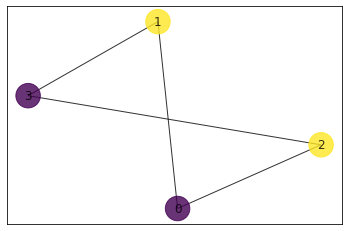

In [24]:
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
colors = colors
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)